# Amazon Food Reviews NLP

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import re

import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
sns.set(style='dark', palette='muted', font_scale=1.1, rc={'figure.figsize': [16, 6]})

## Raw Data

### Amazon Fine Food Reviews Dataset

Download Amazon Fine Food Reviews Dataset

> https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [4]:
DATA_ROOT = 'data'
AMZ_FOOD_DIR = 'amz_fine_food'
AMZ_FOOD_CSV = 'food_reviews.csv'
DATA_AMZ_FOOD = os.path.join(DATA_ROOT, AMZ_FOOD_DIR, AMZ_FOOD_CSV)

In [5]:
df = pd.read_csv(DATA_AMZ_FOOD)
df = df[:6000]

## Data Preprocessing

In [6]:
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

In [7]:
df.shape

(6000, 10)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      6000 non-null   int64 
 1   ProductId               6000 non-null   object
 2   UserId                  6000 non-null   object
 3   ProfileName             6000 non-null   object
 4   HelpfulnessNumerator    6000 non-null   int64 
 5   HelpfulnessDenominator  6000 non-null   int64 
 6   Score                   6000 non-null   int64 
 7   Time                    6000 non-null   int64 
 8   Summary                 6000 non-null   object
 9   Text                    6000 non-null   object
dtypes: int64(5), object(5)
memory usage: 468.9+ KB


In [9]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


### Clean Features

- drop irrelevant
- rename
- drop duplicates
- convert unix epoch to timestamp
- encode categorical
- handle NaN values

In [10]:
df.drop(['Id', 'UserId', 'ProfileName'], axis=1, inplace=True)

In [11]:
col_rename_map = {
    'ProductId': 'product_id',
    'HelpfulnessNumerator': 'helpful_count',
    'HelpfulnessDenominator': 'helpful_total',
    'Score': 'score',
    'Summary': 'summary_text',
    'Text': 'review_text',
    'Time': 'unix_epoch'
}

In [12]:
df.rename(columns=col_rename_map, inplace=True)
df.head(3)

,product_id,helpful_count,helpful_total,score,unix_epoch,summary_text,review_text
0,B001E4KFG0,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [13]:
# drop dupes
df = df.drop_duplicates(subset={"product_id","summary_text","unix_epoch","review_text"})
df.shape

(5996, 7)

In [14]:
# convert unix epoch to date type
df['timestamp'] = pd.to_datetime(df['unix_epoch'], unit='s')
df.drop(columns=['unix_epoch'], inplace=True)
df.head(3)

,product_id,helpful_count,helpful_total,score,summary_text,review_text,timestamp
0,B001E4KFG0,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,B00813GRG4,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
2,B000LQOCH0,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18


In [15]:
prod_id_enc = LabelEncoder()
df.product_id = prod_id_enc.fit_transform(df.product_id)
df.head(3)

,product_id,helpful_count,helpful_total,score,summary_text,review_text,timestamp
0,323,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,885,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
2,190,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18


In [16]:
df.isna().sum()
df.dropna(inplace=True)
df.shape

(5996, 7)

## Feature Engineering

Reduce dimensionality by combining `helpful_count` and `helpful_total`

In [17]:
df['helpful_ratio'] = df['helpful_count'] / df['helpful_total']
df.head(3)

,product_id,helpful_count,helpful_total,score,summary_text,review_text,timestamp,helpful_ratio
0,323,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,1.0
1,885,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,NaN
2,190,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,1.0


## Basic text preprocessing

- Normalize
- Stem
- Remove stopwords

In [18]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec     


def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

unable to import 'smart_open.gcs', disabling that module


In [19]:
df['summary_text'] = df['summary_text'].astype(str).apply(remove_punctuation).str.lower()
df['review_text'] = df['review_text'].astype(str).apply(remove_punctuation).str.lower()
df[['review_text', 'summary_text']].head(3)

,review_text,summary_text
0,i have bought several of the vitality canned d...,good quality dog food
1,product arrived labeled as jumbo salted peanut...,not as advertised
2,this is a confection that has been around a fe...,delight says it all


In [20]:
snow = SnowballStemmer('english')
stops = stopwords.words('english')

In [21]:
# Tokenize, drop stopwords, stem

def stem_tokenize_sents(sents):
    """
    stems and tokenize list of strings
    drops stop words. returns a tuple 
    of stemmed sents and tokenized stemmed 
    sents
    """
    stemmed_sents = []
    stemmed_tokens = []
    for i, sent in enumerate(sents):
        raw_tokens = sent.split()
        local_tokens = []
        for token in raw_tokens:
            if token not in stops:
                local_tokens.append(snow.stem(token))
        stemmed_tokens.append(local_tokens)
        stemmed_sents.append(' '.join(raw_tokens))
    return stemmed_sents, stemmed_tokens

In [22]:
sents = df['review_text']

# get cleaned sentences as strings and as lilst of tokens
clean_sents, clean_tokenized_sents = stem_tokenize_sents(sents)

In [23]:
df['review_tokens'] = clean_tokenized_sents
df['review_clean'] = clean_sents

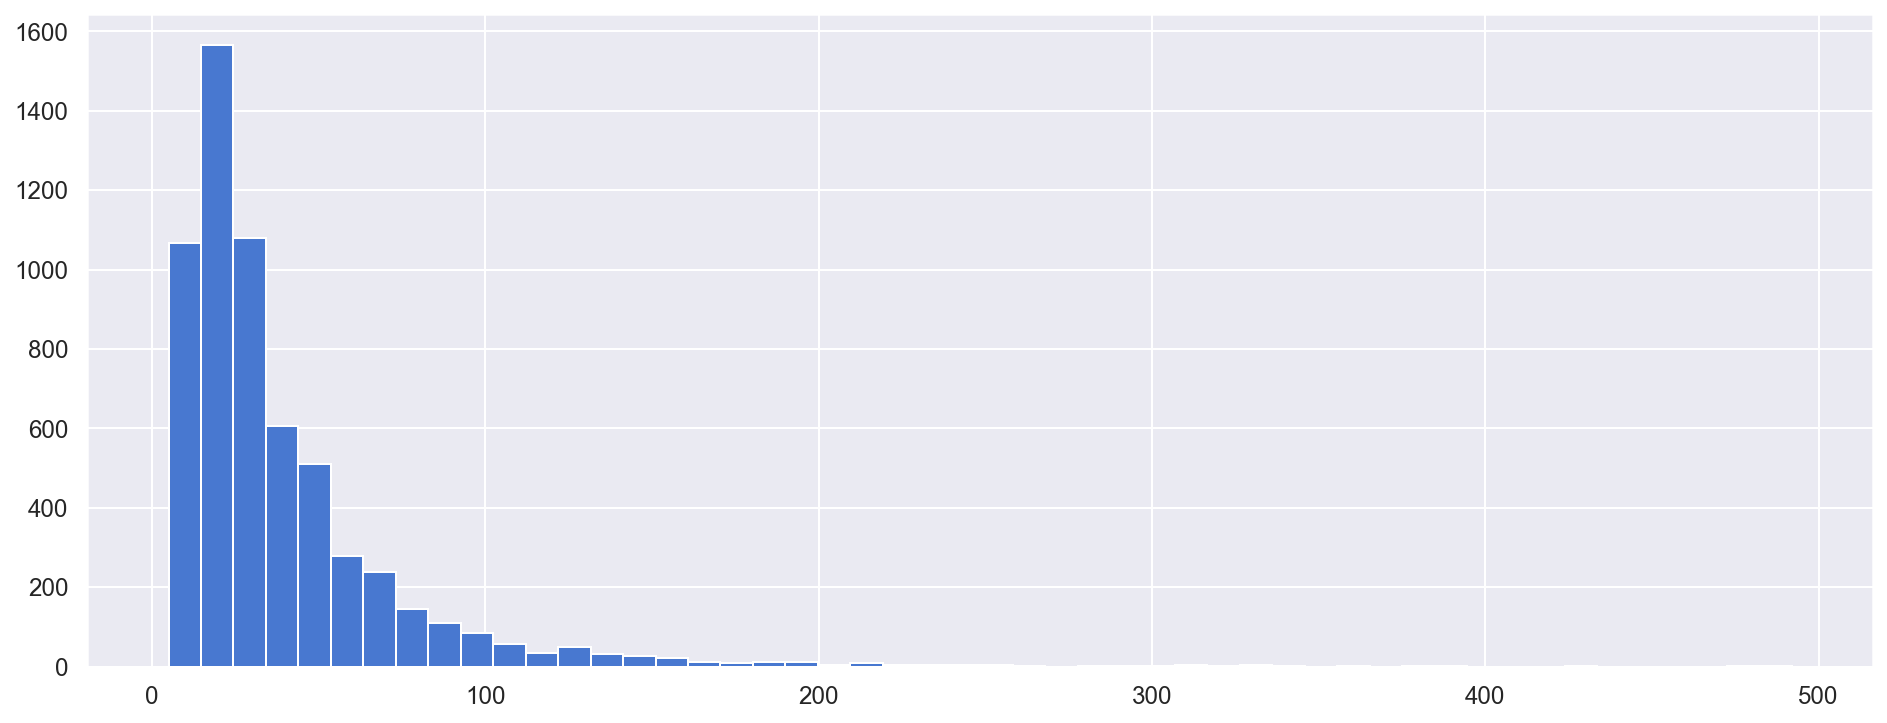

In [24]:
df['review_length'] = df.review_tokens.apply(lambda x: len(x))
df['review_length'].hist(bins=50)

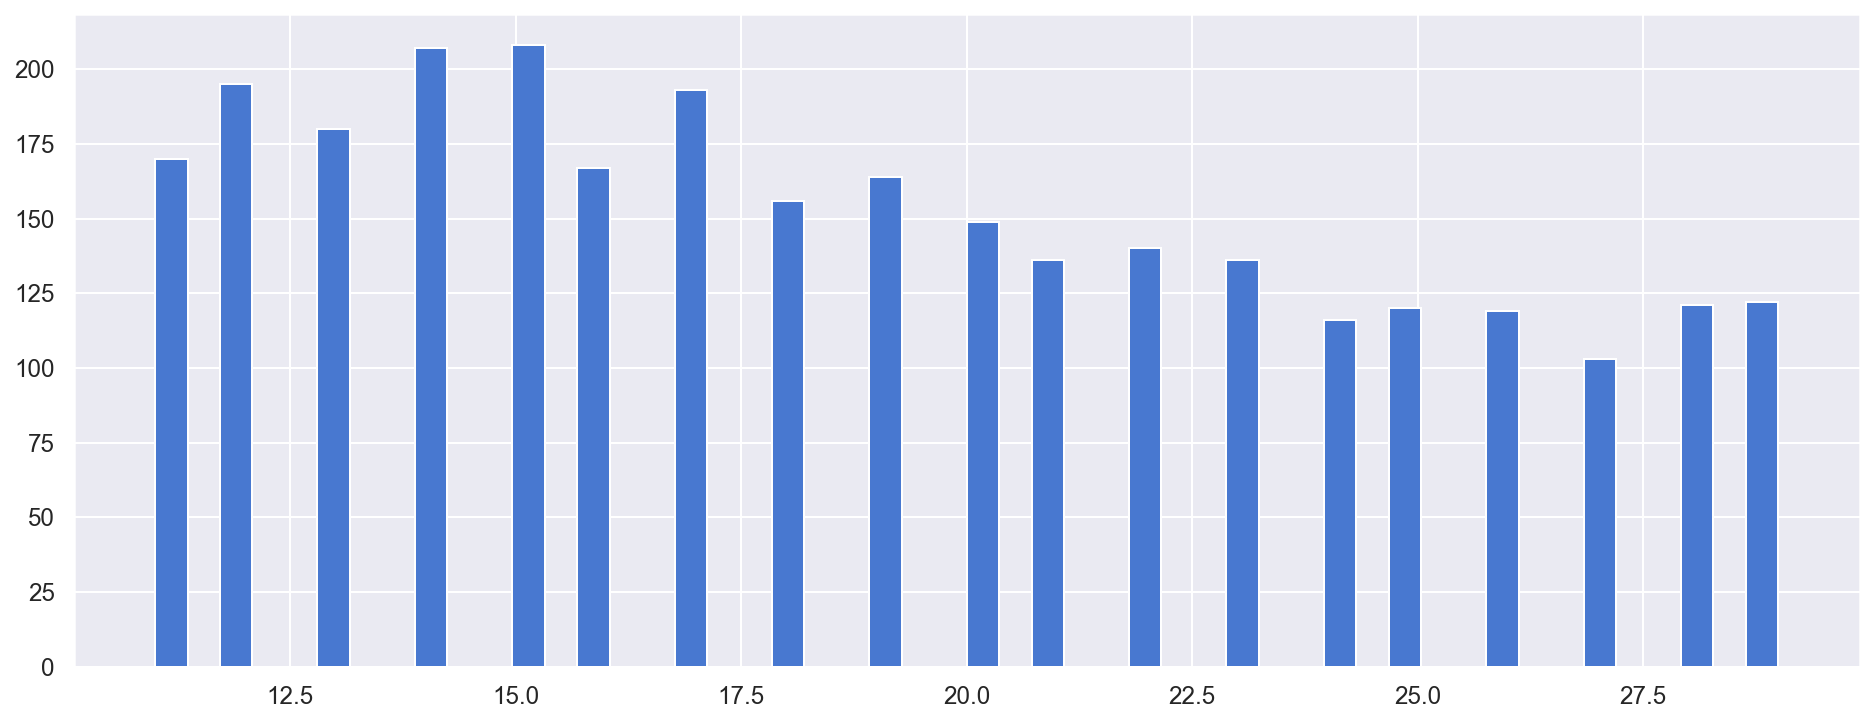

In [25]:
df = df[(df['review_length'] < 30) & (df['review_length'] > 10)]
df['review_length'].hist(bins=50)

In [26]:
df.head(3)

,product_id,helpful_count,helpful_total,score,summary_text,review_text,timestamp,helpful_ratio,review_tokens,review_clean,review_length
0,323,1,1,5,good quality dog food,i have bought several of the vitality canned d...,2011-04-27,1.0,"[bought, sever, vital, can, dog, food, product...",i have bought several of the vitality canned d...,23
1,885,0,0,1,not as advertised,product arrived labeled as jumbo salted peanut...,2012-09-07,NaN,"[product, arriv, label, jumbo, salt, peanutsth...",product arrived labeled as jumbo salted peanut...,18
3,234,3,3,2,cough medicine,if you are looking for the secret ingredient i...,2011-06-13,1.0,"[look, secret, ingredi, robitussin, believ, fo...",if you are looking for the secret ingredient i...,18


In [27]:
df.shape

(2902, 11)

## TFIDF Vectors

In [28]:
tf_idf = TfidfVectorizer(max_features=5000, min_df=7, max_df=0.8, ngram_range=(1, 2))
tf_data = tf_idf.fit_transform(df['review_clean']).toarray()

In [29]:
tf_idf.vocabulary_['highly recommend']

1200

In [30]:
tf_data[:3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [31]:
# each vector is size of vocabulary
len(tf_data[5])

3142

In [32]:
len(tf_data)

2902

## Split Data

In [33]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample

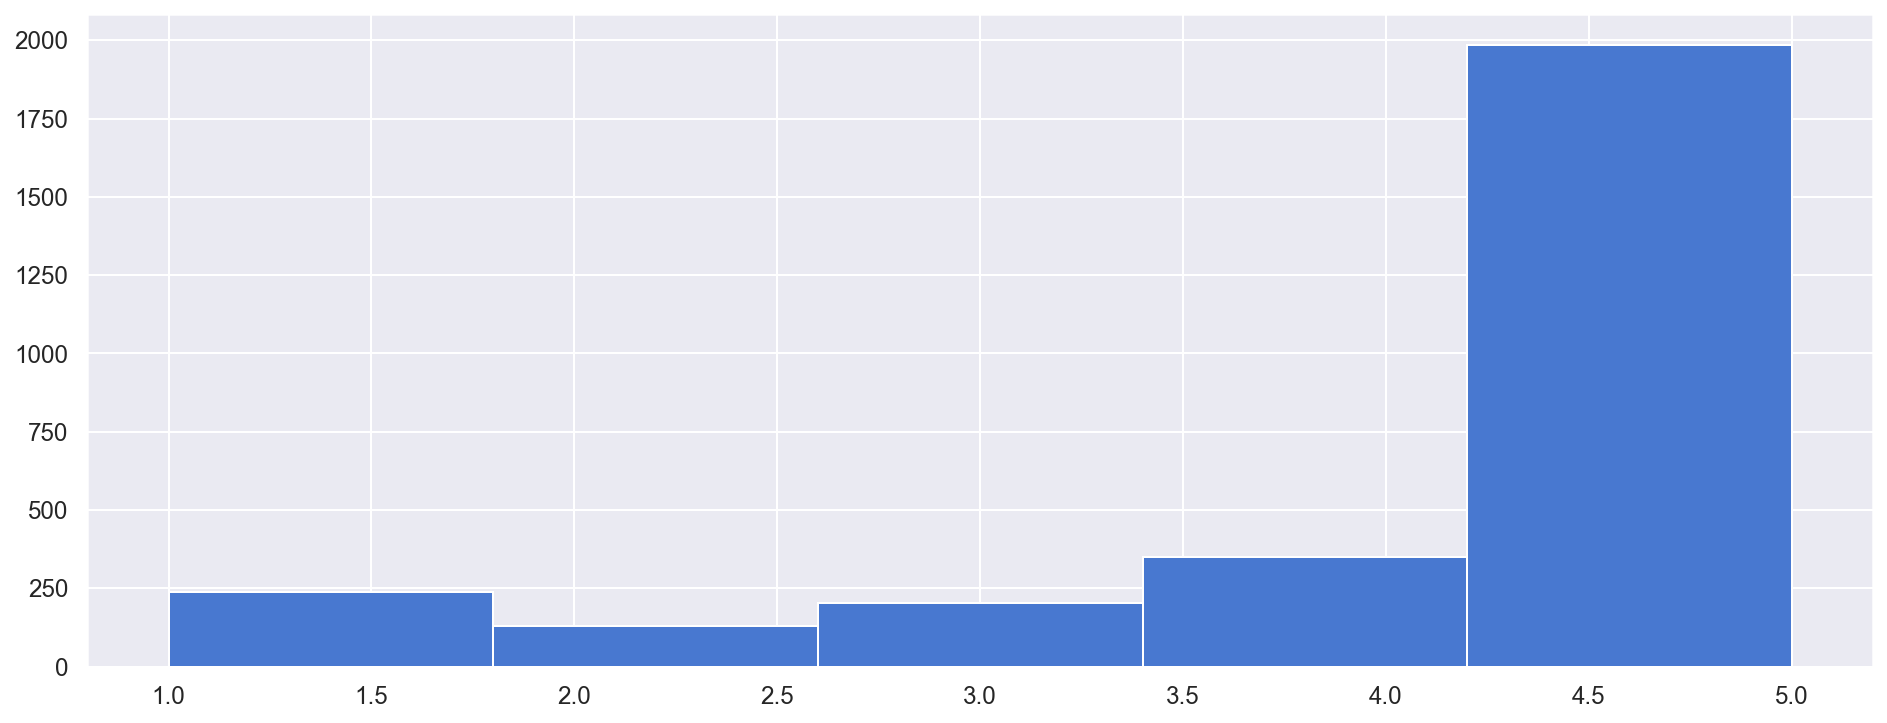

In [34]:
df.score.hist(bins=5)

### The Problem with Imbalanced Classes

Typically, we want balanced classes to train machine learning models. Many algorithms work to maximize accuracy. Think about accuracy as a metric - we could just predict the value of the review to be 5.0 and already achieve ~65% accuracy, much higher than random choice in this case.

In [35]:
five_percent = len(df[df['score'] == 5]) / len(df) * 100
round(five_percent, 2)

68.37

In [36]:
df.groupby('score').describe()

product_id                                                              \
           count        mean         std   min     25%    50%     75%    max   
score                                                                          
1          237.0  424.198312  255.466238  10.0  175.00  410.0  650.00  911.0   
2          129.0  431.379845  249.514535  24.0  225.00  428.0  650.00  852.0   
3          202.0  451.178218  250.355683  11.0  251.25  428.0  658.25  893.0   
4          350.0  453.774286  264.103594   0.0  200.75  428.0  711.75  893.0   
5         1984.0  435.007056  253.172466   1.0  223.00  428.0  650.00  912.0   

      helpful_count            ... helpful_ratio      review_length  \
              count      mean  ...           75%  max         count   
score                          ...                                    
1             237.0  1.561181  ...           1.0  1.0         237.0   
2             129.0  1.093023  ...           1.0  1.0         129.0   
3             202.0  1.272277  ...           1.0  1.0         202.0   
4             350.0  0.934286  ...           1.0  1.0         350.0   
5            1984.0  0.875000  ...           1.0  1.0        1984.0   

                                                           
            mean       std   min    25%   50%   75%   max  
score                                                      
1      19.742616  5.470762  11.0  15.00  19.0  25.0  29.0  
2      19.395349  4.861228  11.0  15.00  19.0  23.0  29.0  
3      19.554455  5.441640  11.0  14.25  19.5  24.0  29.0  
4      18.920000  5.466690  11.0  14.00  18.0  23.0  29.0  
5      18.810988  5.355074  11.0  14.00  18.0  23.0  29.0  

[5 rows x 40 columns]

In [37]:
# target
y = df['score']

In [38]:
len(df)

2902

In [39]:
X_train, X_test, y_train, y_test = train_test_split(tf_data, y, test_size=0.2, random_state=8)

In [40]:
X_train[:20]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Classifiers

### Random Forest

In [41]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [42]:
text_classifier = RandomForestClassifier(n_estimators=500, random_state=0)
text_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [43]:
# Make predictions on test data
predictions = text_classifier.predict(X_test)

In [44]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[  1   0   0   0  53]
 [  0   0   0   0  25]
 [  0   0   1   1  33]
 [  0   0   0   0  80]
 [  1   0   0   0 386]]
              precision    recall  f1-score   support

           1       0.50      0.02      0.04        54
           2       0.00      0.00      0.00        25
           3       1.00      0.03      0.06        35
           4       0.00      0.00      0.00        80
           5       0.67      1.00      0.80       387

    accuracy                           0.67       581
   macro avg       0.43      0.21      0.18       581
weighted avg       0.55      0.67      0.54       581

0.6678141135972461


### Gaussian Naive Bayes

In [45]:
from sklearn.naive_bayes import GaussianNB

In [46]:
text_classifier = GaussianNB()
text_classifier.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [47]:
predictions = text_classifier.predict(X_test)

In [48]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[  3   0   1   3  47]
 [  0   0   1   1  23]
 [  1   0   1   4  29]
 [  0   0   0   4  76]
 [  2   0   1  18 366]]
              precision    recall  f1-score   support

           1       0.50      0.06      0.10        54
           2       0.00      0.00      0.00        25
           3       0.25      0.03      0.05        35
           4       0.13      0.05      0.07        80
           5       0.68      0.95      0.79       387

    accuracy                           0.64       581
   macro avg       0.31      0.22      0.20       581
weighted avg       0.53      0.64      0.55       581

0.6437177280550774


### K-Nearest Neighbors

In [49]:
from sklearn.neighbors import KNeighborsClassifier

text_classifier = KNeighborsClassifier()
text_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [50]:
predictions = text_classifier.predict(X_test)

In [51]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[  6   0   1   5  42]
 [  5   2   1   1  16]
 [  5   1   2   9  18]
 [  4   1   4   4  67]
 [  7   2   7  10 361]]
              precision    recall  f1-score   support

           1       0.22      0.11      0.15        54
           2       0.33      0.08      0.13        25
           3       0.13      0.06      0.08        35
           4       0.14      0.05      0.07        80
           5       0.72      0.93      0.81       387

    accuracy                           0.65       581
   macro avg       0.31      0.25      0.25       581
weighted avg       0.54      0.65      0.57       581

0.6454388984509466


### Neural Network

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

In [66]:
model = Sequential([
    Dense(32, input_shape=(3142,)),
    Activation('relu'),
    Dense(128),
    Activation('softmax'),
    Dense(6)
])

In [67]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                100576    
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4224      
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 105,574
Trainable params: 105,574
Non-trainable params: 0
_________________________________________________________________


#### One-hot encode target for NN

In [71]:
from sklearn.preprocessing import LabelBinarizer

In [72]:
y = LabelBinarizer().fit_transform(y_train)

In [73]:
y[:3]

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0]])

In [74]:
# For a multi-class classification problem
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Train the model, iterating on the data in batches of 32 samples
model.fit(X_train, y_train, epochs=1000, batch_size=32)

In [ ]:
y_test = LabelBinarizer().fit_transform(y_test)

In [ ]:
y_test[:10]

In [ ]:
score = model.evaluate(X_test, y_test, batch_size=128)

## Sentiment Analysis

### Crude Sentiment Analysis

In [ ]:
positive_words = [
    'good', 'great', 'love', 'loved', 'fantastic', 
    'delicious', 'excellent', 'satisfied', 'well', 'nice', 
    'perfect', 'perfectly', 'thanks', 'thank', 'tasty', 'fun'
]

negative_words = [
    'bad', 'horrible', 'disappointed', 'damaged', 
    'terrible', 'hate', 'garbage', 'worthless',
    'cheap', 'wrong', 'frustrating', 'frustrated',
    'disgusting', 'gross', 'horrible', 'nasty',
    'spoiled', 'stale', 'watery'
]

def sum_count_in_list(words, word_list):
    count = 0
    for word in words:
        if word in word_list:
            count += 1
    return count

In [ ]:
df['pos_word_count'] = df['review_tokens'].apply(lambda x: sum_count_in_list(x, positive_words))
df['neg_word_count'] = df['review_tokens'].apply(lambda x: sum_count_in_list(x, negative_words))

In [ ]:
df.head(3)

In [ ]:
df_corr = df[['pos_word_count', 'neg_word_count', 'review_length', 'score']].corr()
df_corr

In [ ]:
sns.heatmap(df_corr, annot=True)